# Estimator Analysis

Understand the Logistic Regression estimator that was chosen as the best performer in [parameter_optimization](parameter_optimization.ipynb).

### Get the data  from [property_calculations](property_calculations.ipynb) and grid search data from [parameter_optimization](parameter_optimization.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project',
                           'fp')

dataset_path = path.join(BASE_DATA_PATH,
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']
test_features = dataset['test features']
test_labels = dataset['test labels']

grids_path = path.join(BASE_DATA_PATH,
                      'parameter_optimization',
                      'grids.pkl')

with open(grids_path, 'rb') as g:
    grids = pickle.load(g)

### Logistic Regression estimator analysis

In [2]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(class_weight='balanced', random_state=42)
LR_params = {'estimator': [LR],
             'estimator__C': 10.0 ** -np.arange(-4, 4),
             'estimator__solver': ['lbfgs', 'sag', 'newton-cg']}

In [3]:
lr_grid = grids['lr']
lr_grid.best_params_

{'estimator': LogisticRegression(C=0.10000000000000001, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
 'estimator__C': 0.10000000000000001,
 'estimator__solver': 'lbfgs'}

In [4]:
from sklearn.model_selection import cross_val_score

lr_grid = grids['lr']
lr = lr_grid.best_estimator_
lr_roc = cross_val_score(lr, train_features, train_labels, cv=4, scoring='roc_auc')

In [6]:
import scipy.stats as st

mean, sem = np.mean(lr_roc), st.sem(lr_roc)
interval = st.t.interval(0.95, len(lr_roc)-1, loc=mean, scale=sem)
delta = mean - interval[0]
print('Mean Area under Receiver Operating Characteristic curve: {:.2f} +/- {:.2f}' 
      .format(mean, delta))

Mean Area under Receiver Operating Characteristic curve: 0.85 +/- 0.03


In [7]:
lr_ap_scores = cross_val_score(lr, 
                               train_features, train_labels,
                               cv=4, scoring='average_precision')

In [8]:
long_string = 'Area under recall_precision curve is {:.1f} times\
 greater than expected if clasifier were random'

proportion_positives = sum(train_labels)/train_labels.shape[0]
print(long_string 
      .format(np.mean(lr_ap_scores)/proportion_positives))

Area under recall_precision curve is 4.4 times greater than expected if clasifier were random


In [9]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import matthews_corrcoef, make_scorer

math_scorer = make_scorer(matthews_corrcoef)

param_range_C = 10.0 ** -np.arange(-4, 4)

train_scores_C, test_scores_C = validation_curve(
        lr,
        train_features, train_labels,
        param_name='estimator__C', 
        param_range=param_range_C,
        cv=4, scoring=math_scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__C=10000.0 ............................................
[CV] estimator__C=1000.0 .............................................
[CV] estimator__C=100.0 ..............................................
[CV] estimator__C=10.0 ...............................................
[CV] ............................. estimator__C=10000.0, total=   3.3s
[CV] estimator__C=1.0 ................................................
[CV] ............................... estimator__C=100.0, total=   3.4s
[CV] estimator__C=0.1 ................................................
[CV] ................................ estimator__C=10.0, total=   3.4s
[CV] .............................. estimator__C=1000.0, total=   3.6s
[CV] estimator__C=0.01 ...............................................
[CV] estimator__C=0.001 ..............................................
[CV] ............................... estimator__C=0.001, total=   1.1s
[CV] estimator__C=10000.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:   12.7s remaining:   12.7s


[CV] .............................. estimator__C=1000.0, total=   3.1s
[CV] estimator__C=1.0 ................................................
[CV] ............................. estimator__C=10000.0, total=   3.4s
[CV] estimator__C=0.1 ................................................
[CV] ............................... estimator__C=100.0, total=   3.1s
[CV] estimator__C=0.01 ...............................................
[CV] ................................ estimator__C=10.0, total=   3.2s
[CV] estimator__C=0.001 ..............................................
[CV] ............................... estimator__C=0.001, total=   1.1s
[CV] estimator__C=10000.0 ............................................
[CV] ................................ estimator__C=0.01, total=   1.4s
[CV] estimator__C=1000.0 .............................................
[CV] ................................. estimator__C=0.1, total=   2.7s
[CV] estimator__C=100.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   24.1s finished


In [11]:
import scipy.stats as st

def t_delta(percent, scores):
    '''
    Returns the size of a t-test error bar that defines a given percent confidence interval 
    '''
    mean, sem = np.mean(scores, axis=1), st.sem(scores, axis=1)
    interval = st.t.interval(percent/float(100), len(scores)-1, loc=mean, scale=sem)
    delta = mean - interval[0]
    return mean, delta

def plot_val_curve(train_scores, test_scores, param_range, xlabel='modified parameter'):
    train_scores_mean = t_delta(95, train_scores)[0]
    train_scores_std = t_delta(95, train_scores)[1]
    test_scores_mean = t_delta(95, test_scores)[0]
    test_scores_std = t_delta(95, test_scores)[1]
    
    fig, ax = plt.subplots()
    fig.suptitle('Validation Curve')
    fig.set_size_inches(10,8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Matthews correlation')
    ax.grid()
    lw = 2
    ax.semilogx(param_range, train_scores_mean, label='Training score',
                 color='darkorange', lw=lw)
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='darkorange', lw=lw)
    ax.semilogx(param_range, test_scores_mean, label='Cross-validation score',
                 color='navy', lw=lw)
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color='navy', lw=lw)
    ax.legend(loc='best')
    plt.show()
    return fig

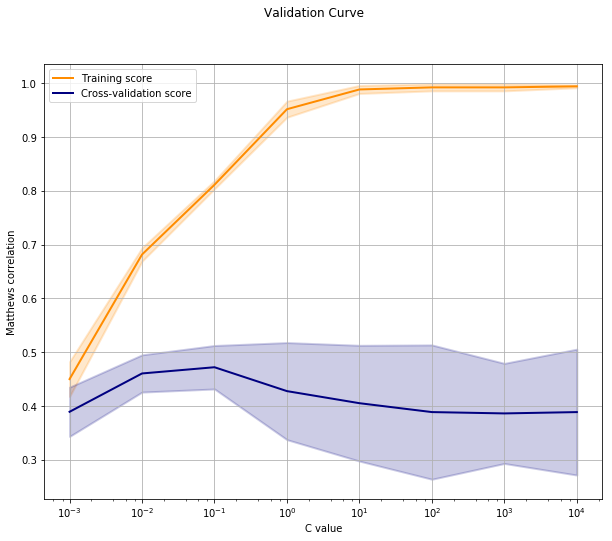

In [12]:
fig = plot_val_curve(train_scores_C, test_scores_C, param_range_C, xlabel='C value')
fig.savefig('Images/3_val_curve.png')

The estimator's C value is at the sweet spot with the highest score, and lowest amount of variability:

- Anything below $10^{-1}$ produces an underfit (high bias) model, with low training and test scores. 

- Anything above $10^{-1}$ produces an overfit (high variance) model, with high training scores that don't generalize to the test data.

In [23]:
param_range_solver = ['lbfgs', 'sag', 'newton-cg']

train_scores_solver, test_scores_solver = validation_curve(
        lr,
        train_features, train_labels,
        param_name='estimator__solver', 
        param_range=param_range_solver,
        cv=4, scoring=math_scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__solver=lbfgs .........................................
[CV] estimator__solver=sag ...........................................
[CV] estimator__solver=newton-cg .....................................
[CV] estimator__solver=lbfgs .........................................
[CV] .......................... estimator__solver=lbfgs, total=   2.1s
[CV] estimator__solver=sag ...........................................
[CV] .......................... estimator__solver=lbfgs, total=   2.4s
[CV] estimator__solver=newton-cg .....................................
[CV] ...................... estimator__solver=newton-cg, total=   3.4s
[CV] estimator__solver=lbfgs .........................................
[CV] .......................... estimator__solver=lbfgs, total=   2.0s
[CV] estimator__solver=sag ...........................................
[CV] ...................... estimator__solver=newton-cg, total=   3.1s
[CV] estimator__solver=newton-cg .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    8.7s remaining:    8.7s


[CV] .......................... estimator__solver=lbfgs, total=   1.3s
[CV] estimator__solver=sag ...........................................


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  13.7s
[CV] estimator__solver=newton-cg .....................................


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  13.5s
[CV] ...................... estimator__solver=newton-cg, total=   2.5s


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  12.4s


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  10.8s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   21.1s finished


In [116]:
def plot_val_bar(train_scores, test_scores, param_range, xlabel='modified parameter'):
    train_scores_mean = t_delta(95, train_scores)[0]
    train_scores_std = t_delta(95, train_scores)[1]
    test_scores_mean = t_delta(95, test_scores)[0]
    test_scores_std = t_delta(95, test_scores)[1]
    
    locs = np.arange(len(param_range))
    
    fig, ax = plt.subplots()
    ax.set_title('Validation Bars')
    ax.set_ylabel('Matthews correlation')
    ax.set_xlabel(xlabel, size=12)
    ax.bar(locs, train_scores_mean, yerr=train_scores_std,
           width=-0.4, align='edge',
           label='Training score', 
           color='darkorange', alpha=0.5)
    ax.bar(locs, test_scores_mean, yerr=test_scores_std,
           width=0.4, align='edge',
           label='Test score',
           color='navy', alpha=0.5)
    ax.set_xticks(locs)
    ax.set_xticklabels(param_range)
    ax.legend(loc='lower right')
    plt.show()

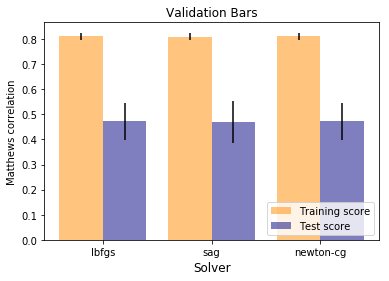

In [117]:
plot_val_bar(train_scores_solver, test_scores_solver, 
             param_range_solver, xlabel='Solver')

At least with this size dataset the solver used by the Logistic Regression estimator does not seem to make much of a difference. 

In [15]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(train_sizes, train_scores, test_scores):
    """
    TODO
    """
    train_scores_mean = t_delta(95, train_scores)[0]
    train_scores_std = t_delta(95, train_scores)[1]
    test_scores_mean = t_delta(95, test_scores)[0]
    test_scores_std = t_delta(95, test_scores)[1]
    
    fig, ax = plt.subplots()
    fig.suptitle('Learning Curve')
    fig.set_size_inches(10,8)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Matthews correlation')
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='darkorange')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='navy')
    ax.plot(train_sizes, train_scores_mean, 'o-', color='darkorange',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='navy',
             label='Test score')

    ax.legend(loc='best')
    plt.show()
    return fig

In [16]:
train_sizes, train_scores, test_scores = learning_curve(
        lr, train_features, train_labels, cv=4, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1, 5),
        scoring=math_scorer,
        verbose=2
)

[learning_curve] Training set sizes: [ 113  370  626  882 1139]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  .......

[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    5.4s remaining:    5.4s


[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.8s
[CV]  ................................................................
[CV] ................................................. , total=   1.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV] ................................................. , total=   1.6s
[CV] .

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.2s finished


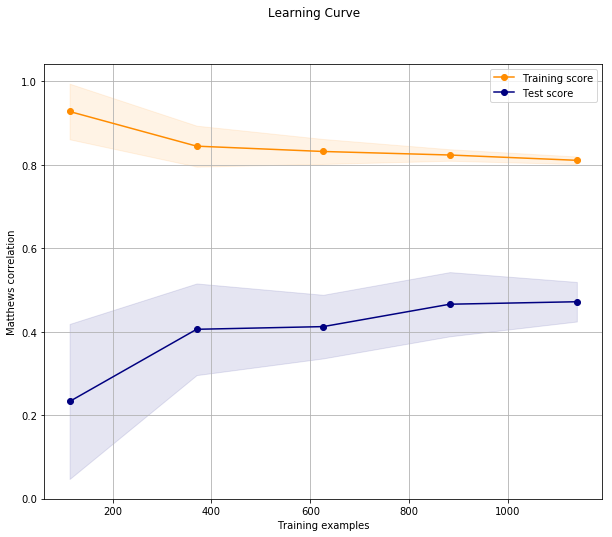

In [18]:
fig = plot_learning_curve(train_sizes, train_scores, test_scores)
fig.savefig('Images/4_learn_curve.png')

The learning curve argues that the current model is still relatively overfit (high variance) due to a persitent gap between training and test scores, regardless of training example size. 

This suggests that the best way to further improve this estimator would be to __add more training examples__.

In [128]:
from sklearn.metrics import roc_auc_score
lr.fit(train_features, train_labels)
pred = lr.predict(test_features)
test_score = roc_auc_score(test_labels, pred, average='weighted')

In [130]:
print('Mean Area under Receiver Operating Characteristic curve: {:.2f} ' 
      .format(test_score))

Mean Area under Receiver Operating Characteristic curve: 0.76 


This ROCAUC score on our test data indicates that the estimator has a __0.76 probability of ranking a random savory chemical above a random non-savory chemical__. The test score being almost 0.1 lower than our cross_validated training scores (and 0.6 below their 95% confidence range) further argues that the model is overfit and could use more training data to improve the final score.

### Determine if there is any chemistry to be learned from the features the estimator considers the most informative

In [179]:
dataset_path = path.join(BASE_DATA_PATH,
                         'property_calculations',
                         'full_labels.pkl')

with open(dataset_path, 'rb') as f:
    full_labels = pickle.load(f)

In [180]:
# Remove class labels from labels
full_labels = np.array(full_labels[1:])
# Get importance coefficients
coefficients = lr.steps[-1][1].coef_
# Find the indexes that would sort coefficients from largest to smallest
sorting_is = np.argsort(coefficients)
sorting_is = np.fliplr(sorting_is)
# Apply to feature labels
sorted_labels = full_labels[sorting_is][0]

In [181]:
# Printout non-fingerprint related feature names
count = 1
for i, label in enumerate(sorted_labels):
    if label in ['morgan', 'topo']:
        continue
    else:
        print('Descriptor: {} ranked {}' .format(label, i+1))
        count += 1
    if count > 10:
        break

Descriptor: maccs_36 ranked 16
Descriptor: fr_SH ranked 23
Descriptor: PEOE_VSA4 ranked 45
Descriptor: SlogP_VSA12 ranked 50
Descriptor: SMR_VSA10 ranked 54
Descriptor: fr_unbrch_alkane ranked 61
Descriptor: VSA_EState10 ranked 111
Descriptor: maccs_29 ranked 130
Descriptor: maccs_25 ranked 156
Descriptor: NumRotatableBonds ranked 165


The 10 most informative human readabale descriptors are:

1) [Molecular ACCess System](https://en.wikipedia.org/wiki/MDL_Information_Systems) (MACCS) key # 36: Rings containing sulfur.

2) fr_SH: Number of thiol groups.

3) PEOE_VSA4: Charge estimation -[MOE Charge VSA](http://www.chemcomp.com/journal/vsadesc.htm) Descriptor 4.

4) SlogP_VSA12: Water/Octanol solubility calculation -[MOE logP VSA](http://www.chemcomp.com/journal/vsadesc.htm) Descriptor 12.

5) SMR_VSA10: Molecular refractivity calculation -[MOE MR VSA](http://www.chemcomp.com/journal/vsadesc.htm) calculation descriptor 10.

6) fr_unbrch_alkane: Number of [unbranched alkanes](https://en.wikipedia.org/wiki/Alkane#Linear_alkanes) of at least 4 members (excludes halogenated alkanes).

7) VSA_EState10: [van der Waals surface area calculation](http://rdkit.org/docs/api/rdkit.Chem.EState.EState_VSA-module.html).

8) MACCS key # 29: Number of Phosphorous atoms.

9) MACCS key # 25: NC(N)N signature present.

10) NumRotatableBonds: Number of rotatable bonds .